In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from time import time
from sklearn.metrics import roc_auc_score
import networkx as nx
from scipy.stats import wasserstein_distance

In [2]:
import BiMent

## Get Data

In [3]:
# Apps By Week
df = pd.read_csv('/Users/tradergllc/rsi/datasets/reality-mining/txt/interim/appsByWeek-clean.txt', 
                 sep=', ', header=None, engine='python', dtype=str, names=['id', 'date', 'app', 'freq'])

In [4]:
def convert_to_dict(df):
    data_dict = {}
    
    unique = list(df.iloc[:, 2].unique())
    
    date_list = [df.iloc[0, 1]]
    pid_date_list = [(df.iloc[0,0], df.iloc[0, 1])]
    
    data_dict[int(df.iloc[0,0])] = {}
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]] = np.zeros((len(unique),))
    data_dict[int(df.iloc[0,0])][df.iloc[0, 1]][unique.index(df.iloc[0, 2])] = 1
        
    for r in range(1, len(df.index)):
        pid = int(df.iloc[r, 0])
        if pid not in data_dict.keys():
            data_dict[pid] = {}        
        
        if (df.iloc[r, 0], df.iloc[r, 1]) in pid_date_list:
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1 #df.iloc[r, 3]
        else:
            date_list.append(df.iloc[r, 1])
            pid_date_list.append((df.iloc[r, 0], df.iloc[r, 1]))
            
            data_dict[pid][df.iloc[r, 1]] = np.zeros((len(unique),))
            data_dict[pid][df.iloc[r, 1]][unique.index(df.iloc[r, 2])] = 1
                        
    return data_dict, unique

In [5]:
data_dict, unique = convert_to_dict(df)

In [6]:
def dict_to_np_array(d):
    vector_list = []
    gt_pid = []
    idx_list = []
    for pid in d.keys():
        for date in d[pid].keys():
            vector_list.append(d[pid][date])
            gt_pid.append(d.keys().index(pid))
            idx_list.append((pid, date))
    return np.stack(vector_list), np.array(gt_pid), idx_list

In [7]:
x_train, y_train, idx_list = dict_to_np_array(data_dict)
print x_train.shape, y_train.shape

(1911, 206) (1911,)


In [8]:
idx_list[:10]

[(3, '2004.36'),
 (3, '2004.37'),
 (3, '2004.34'),
 (3, '2004.35'),
 (3, '2004.47'),
 (3, '2004.51'),
 (3, '2004.49'),
 (3, '2004.48'),
 (3, '2004.39'),
 (3, '2005.1')]

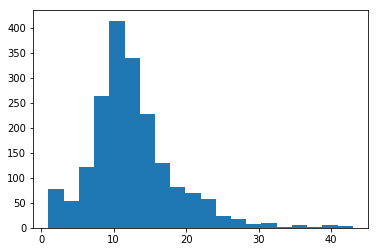

In [9]:
plt.hist(x_train.sum(axis=1), bins=20)
plt.show()

In [10]:
# x_max = x_train.sum(axis=1).max()
# p_max = 0.75
# p = -(p_max / x_max)*np.arange(x_max) + p_max
# p = p / p.sum()
# print p

In [11]:
# choice = np.random.choice(np.arange(x_max), 75, replace=True, p=p)

In [12]:
# plt.hist(choice, bins=20)
# plt.show()

## Weighted Correlation

### Generate Test Data

In [13]:
N_SINGLETONS = 75
N_PAIRS = 5
N_TOTAL = N_SINGLETONS + 2 * N_PAIRS

In [14]:
singletons = np.random.choice(range(y_train.max() + 1), N_SINGLETONS, replace=False)

remaining_idx = []
for i in np.arange(y_train.max() + 1):
    if i not in singletons:
        remaining_idx.append(i)

pairs = np.random.choice(remaining_idx, N_PAIRS, replace=False)

In [15]:
# vec_list = []
idx_choice = np.zeros((N_TOTAL), dtype=np.int32)
adj_mx = np.zeros((N_TOTAL, x_train.shape[1]))

pid_list = data_dict.keys()

idx_pairs = np.random.choice(range(N_TOTAL), 2 * N_PAIRS, replace=False)
idx_single = []
for i in range(N_TOTAL):
    if i not in idx_pairs:
        idx_single.append(i)
        
GT_POS_PAIRS = [(idx_pairs[2*i], idx_pairs[2*i + 1]) for i in range(N_PAIRS)]

In [16]:
GT_POS_PAIRS

[(29, 61), (17, 20), (10, 50), (6, 0), (34, 69)]

In [17]:
print idx_single

[1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]


In [18]:
for p in range(len(pairs)):
    pid = pid_list[pairs[p]]
    
    w1, w2 = np.random.choice(data_dict[pid].keys(), 2)
    app_vec1, app_vec2 = data_dict[pid][w1], data_dict[pid][w2]

    adj_mx[GT_POS_PAIRS[p][0]] = app_vec1
    adj_mx[GT_POS_PAIRS[p][1]] = app_vec2
    
    idx_choice[GT_POS_PAIRS[p][0]] = idx_list.index((pid, w1))
    idx_choice[GT_POS_PAIRS[p][1]] = idx_list.index((pid, w2))

for s in range(len(singletons)):
    pid = pid_list[singletons[s]]
    
    w = np.random.choice(data_dict[pid].keys(), 1)
    app_vec = data_dict[pid][w[0]]
    adj_mx[idx_single[s]] = app_vec
    
    idx_choice[idx_single[s]] = idx_list.index((pid, w))

In [19]:
print adj_mx

[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


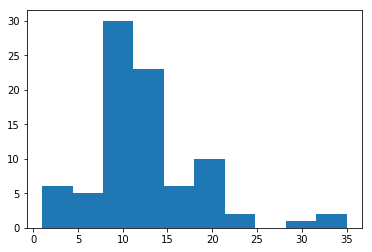

In [20]:
plt.hist(adj_mx.sum(axis=1))
plt.show()

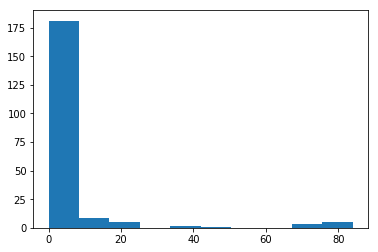

In [21]:
plt.hist(adj_mx.sum(axis=0))
plt.show()

### Baseline

In [22]:
# phi = adj_mx.sum(axis=0) / adj_mx.shape[0]
phi = x_train.sum(axis=0) / x_train.shape[0]
print phi[:20]

[0.93354265 0.92569335 0.16535845 0.89848247 0.50340136 0.06488749
 0.98587127 0.9126112  0.73992674 0.93720565 0.18367347 0.36577708
 0.20565149 0.16012559 0.03192046 0.23600209 0.19832548 0.18576661
 0.04709576 0.8325484 ]


In [23]:
# Ensure all p_i's are non-zero
adj_mx_nonzero = adj_mx.copy()
# adj_mx_nonzero = adj_mx_nonzero[:, np.where(np.logical_and(phi > 0, phi < 1))[0]]

# phi = adj_mx_nonzero.sum(axis=0) / adj_mx_nonzero.shape[0]
# print phi[:20]

In [24]:
# %%timeit
start = time()

WC_arr = []
WC_idx = []
for i in np.arange(adj_mx_nonzero.shape[0]):
    for j in np.arange(i + 1, adj_mx_nonzero.shape[0]):
        X = adj_mx_nonzero[i]
        Y = adj_mx_nonzero[j]
        
        WC = (1.0/ phi.shape[0])* (X- phi)* (Y- phi)/ (phi*(1-phi))
        WC_arr.append(WC.sum())
        
        if (i, j) in GT_POS_PAIRS or (j, i) in GT_POS_PAIRS:
            WC_idx.append(True)
        else:
            WC_idx.append(False)
            
print 'time elapsed: %f sec' % (time() - start)
WC_arr = np.array(WC_arr)
WC_idx = np.array(WC_idx)

time elapsed: 0.075429 sec


In [25]:
WC_arr[WC_idx]

array([0.27221947, 0.00404317, 0.09916039, 0.15287205, 0.04209307])

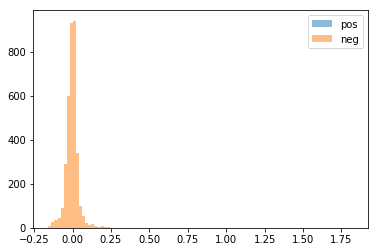

In [26]:
bins = np.linspace(WC_arr.min(), WC_arr.max(), 100)

plt.hist(WC_arr[WC_idx], bins, alpha=0.5, label='pos')
plt.hist(WC_arr[WC_idx == False], bins, alpha=0.5, label='neg')
plt.legend(loc='upper right')
plt.show()

In [27]:
print roc_auc_score(y_true=WC_idx, y_score=WC_arr)

0.8990182328190743


### Estimate Phi using ERGM

In [28]:
np.all(adj_mx == x_train[idx_choice])

True

In [29]:
fs = x_train.sum(axis=1)
gs = x_train.sum(axis=0)
# fs = adj_mx.sum(axis=1)
# gs = adj_mx.sum(axis=0)
X, Y, X_bak, Y_bak = BiMent.solver(fs, gs, tolerance=1e-5, max_iter=10000)

counter=0, change=13.219167
counter=500, change=0.287301
counter=1000, change=0.002021
counter=1500, change=0.000014
Solver done in 13.0 seconds.
Solver converged in 1536 iterations.


In [30]:
phi_all = X[:, None] * Y / (1 + X[:, None] * Y)
# phi_ia = X_bak[:, None] * Y_bak / (1 + X_bak[:, None] * Y_bak)
print phi_all.shape

(1911, 206)


In [31]:
phi_ia = phi_all[idx_choice]
print phi_ia.shape

# choice = np.random.choice(range(x_train.shape[0]), 85, replace=False)
# adj_mx = x_train[choice]
# phi_ia = phi_all[choice]

(85, 206)


In [32]:
# %%timeit
start = time()

WC_arr = []
WC_idx = []
for i in np.arange(adj_mx.shape[0]):
    for j in np.arange(i + 1, adj_mx.shape[0]):
        X = adj_mx[i]
        Y = adj_mx[j]
        E_X = phi_ia[i]
        E_Y = phi_ia[j]
        
        WC = (1.0/ phi_ia.shape[1])* (X- E_X)* (Y- E_Y)/ (np.sqrt(E_X*E_Y*(1-E_X)*(1-E_Y)) + 1e-6)
        WC_arr.append(WC.sum())
        
        if (i, j) in GT_POS_PAIRS or (j, i) in GT_POS_PAIRS:
            WC_idx.append(True)
        else:
            WC_idx.append(False)
            
print 'time elapsed: %f sec' % (time() - start)
WC_arr = np.array(WC_arr)
WC_idx = np.array(WC_idx)

time elapsed: 0.093637 sec


In [33]:
print WC_arr[WC_idx]

[0.12622247 0.00672946 0.23955225 0.0109548  0.04271362]


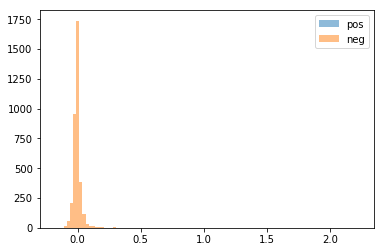

In [34]:
bins = np.linspace(WC_arr.min(), WC_arr.max(), 100)

# plt.hist(WC_arr, bins, alpha=0.5, label='pos')

plt.hist(WC_arr[WC_idx], bins, alpha=0.5, label='pos')
plt.hist(WC_arr[WC_idx == False], bins, alpha=0.5, label='neg')

plt.legend(loc='upper right')
plt.show()

In [35]:
print roc_auc_score(y_true=WC_idx, y_score=WC_arr)

0.8952594670406733


### Genetic Algorithm

In [80]:
def generateFirstPopulation(phi_ia, n_pop=100):
    population = []
    for _ in range(n_pop):
        phi_shuffle = phi_ia.copy()
        np.random.shuffle(phi_shuffle)
        population.append(phi_shuffle.reshape((1,)+phi_shuffle.shape))
    return np.concatenate(population)

In [81]:
phi_population = generateFirstPopulation(phi_ia)
print phi_population.shape

(100, 85, 206)


In [82]:
def fitness(adj_mx, phi_ia, GT_POS_PAIRS, WC_arr_ref):
    WC_arr = []
    WC_idx = []
    for i in np.arange(adj_mx.shape[0]):
        for j in np.arange(i + 1, adj_mx.shape[0]):
            X = adj_mx[i]
            Y = adj_mx[j]
            E_X = phi_ia[i]
            E_Y = phi_ia[j]

            WC = (1.0/ phi_ia.shape[1])* (X- E_X)* (Y- E_Y)/ (np.sqrt(E_X*E_Y*(1-E_X)*(1-E_Y)) + 1e-6)
            WC_arr.append(WC.sum())

            if (i, j) in GT_POS_PAIRS or (j, i) in GT_POS_PAIRS:
                WC_idx.append(True)
            else:
                WC_idx.append(False)
    
#     WC_median = np.median(WC_arr)
#     WC_mean = np.mean(WC_arr)
    
    fit_score = wasserstein_distance(WC_arr, WC_arr_ref) #WC_mean - WC_median
    auc = roc_auc_score(y_true=WC_idx, y_score=WC_arr)
    
    return auc, fit_score

In [83]:
def computeFitnessPopulation(adj_mx, phi_population, GT_POS_PAIRS, WC_arr_ref):
    fitness_list = []
    auc_list = []
    for phi_ia in phi_population:
        auc, fit = fitness(adj_mx, phi_ia, GT_POS_PAIRS, WC_arr_ref)
#         print fit, auc
        fitness_list.append(fit)
        auc_list.append(auc)
    return fitness_list, auc_list

In [96]:
population_fitness, auc_list = computeFitnessPopulation(adj_mx, phi_population, GT_POS_PAIRS, WC_arr)
# print population_fitness

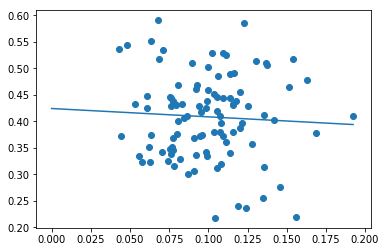

In [97]:
from scipy.stats import pearsonr

R = pearsonr(population_fitness, auc_list)
m, b = np.polyfit(population_fitness, auc_list, 1)

x = np.linspace(0, np.max(population_fitness), 20)
plt.plot(x, m*x + b)
plt.scatter(population_fitness, auc_list)
plt.show()

In [ ]:
def selectFromPopulation

In [ ]:
def createChild(phi1, phi2)

In [ ]:
def createChildren

In [ ]:
def mutatePhi

In [ ]:
def mutatePopulation